In [51]:
from IPython import get_ipython
from matplotlib import pyplot as plt
import numpy as np
from scipy.sparse import csc_matrix
from scipy import io
from caiman.source_extraction.cnmf.cnmf import load_CNMF
from caiman.base.rois import register_multisession
from caiman.utils import visualization
from caiman.utils.utils import download_demo
from pathlib import Path
import os
import re
import pickle
from datetime import datetime

try:
    if __IPYTHON__:
        get_ipython().run_line_magic('load_ext', 'autoreload')
        get_ipython().run_line_magic('autoreload', '2')
except NameError:
    pass

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [52]:
def load_cnmf_data(file_paths):
    """
    Load CNMF data and extract spatial and template information.
    
    Parameters:
    - file_paths (list of str): List of file paths to the CNMF result files.
    
    Returns:
    - spatial (list): List of spatial components matrices (A) for each session.
    - templates (list): List of templates (Cn) for each session.
    - dims (tuple): Dimensions of the spatial layout from the last loaded file.
    """
    cnmf_list=[]
    spatial = []
    templates = []
    dims = None

    for file_path in file_paths:
        print(file_path)
        cnmf_model = load_CNMF(str(file_path))
        cnmf_list.append(cnmf_model)
        idx_components = cnmf_model.estimates.idx_components  # Idx only for good components
        spatial.append(cnmf_model.estimates.A[:, idx_components])  # Spatial components (A) ## is it A that we should use? Took it from the demo ipynb
        templates.append(cnmf_model.estimates.Cn)  # Template (Cn)  ## is it Cv that we should use? only variable that has the correct dims
        dims = cnmf_model.estimates.dims  # Spatial dimensions

    return cnmf_list, spatial, templates, dims, idx_components


In [53]:
## visualize a compontent
# component_footprint = np.reshape(spatial[0][:,0].toarray(), dims, order='F')
# plt.figure(); 
# plt.imshow(component_footprint, cmap='gray')

In [54]:
# Define file paths to.hdf5 files
directory_path = "/media/toor/T7Shield/Mouse1637/Linear"
session_dates = [name for name in os.listdir(directory_path) if os.path.isdir(os.path.join(directory_path, name))]
if 'Cellreg_processed' in session_dates:
    session_dates.remove('Cellreg_processed')
if 'Caiman_registration' in session_dates:
    session_dates.remove('Caiman_registration')

# sort the session dates
date_format = "%Y-%m-%dT%H_%M_%S"  
sorted_session_dates = sorted(session_dates, key=lambda date: datetime.strptime(date, date_format))
file_paths = ["/media/toor/T7Shield/Mouse1637/Linear" + "/" + session_date + "/caiman/caiman_results.hdf5" for session_date in sorted_session_dates]
first_round = file_paths[0:38]
third_round = file_paths[38:]

In [90]:
mixed_rounds = file_paths[::5] + file_paths[1::5] + [file_paths[38]] # 38 is round 2
# add 3 baseline rounds
mixed_rounds.extend([
    "/media/toor/SeagatePortableDrive/AGING_MICE/Mouse1637/BaselineRecordings/miniscopeBaseline2024-12-13T12_55_37/caiman00/caiman_results.hdf5",
    "/media/toor/SeagatePortableDrive/AGING_MICE/Mouse1637/BaselineRecordings/miniscopeBaseline2024-12-13T12_55_37/caiman01/caiman_results.hdf5",
    "/media/toor/SeagatePortableDrive/AGING_MICE/Mouse1637/BaselineRecordings/miniscopeBaseline2024-12-13T12_55_37/caiman02/caiman_results.hdf5",
    "/media/toor/SeagatePortableDrive/AGING_MICE/Mouse1637/BaselineRecordings/miniscopeBaseline2024-12-13T12_55_37/caiman03/caiman_results.hdf5"
])
len(mixed_rounds)

35

In [56]:
baseline=[ "/media/toor/SeagatePortableDrive/AGING_MICE/Mouse1637/BaselineRecordings/miniscopeBaseline2024-12-13T12_55_37/caiman00/caiman_results.hdf5",
    "/media/toor/SeagatePortableDrive/AGING_MICE/Mouse1637/BaselineRecordings/miniscopeBaseline2024-12-13T12_55_37/caiman01/caiman_results.hdf5",
    "/media/toor/SeagatePortableDrive/AGING_MICE/Mouse1637/BaselineRecordings/miniscopeBaseline2024-12-13T12_55_37/caiman02/caiman_results.hdf5",
    "/media/toor/SeagatePortableDrive/AGING_MICE/Mouse1637/BaselineRecordings/miniscopeBaseline2024-12-13T12_55_37/caiman03/caiman_results.hdf5"]

In [57]:
# sessions13=['/media/toor/T7Shield/Mouse1637/Linear/2024-05-23T18_14_05/caiman/caiman_results.hdf5',
#  '/media/toor/T7Shield/Mouse1637/Linear/2024-05-24T18_42_16/caiman/caiman_results.hdf5',
#  '/media/toor/T7Shield/Mouse1637/Linear/2024-05-25T18_27_34/caiman/caiman_results.hdf5',
#  '/media/toor/T7Shield/Mouse1637/Linear/2024-05-26T14_39_05/caiman/caiman_results.hdf5',
# '/media/toor/T7Shield/Mouse1637/Linear/2024-06-25T18_04_58/caiman/caiman_results.hdf5',
#  '/media/toor/T7Shield/Mouse1637/Linear/2024-06-26T14_39_53/caiman/caiman_results.hdf5',
#  '/media/toor/T7Shield/Mouse1637/Linear/2024-06-27T16_43_57/caiman/caiman_results.hdf5',
#  '/media/toor/T7Shield/Mouse1637/Linear/2024-06-28T14_00_26/caiman/caiman_results.hdf5',
#  '/media/toor/T7Shield/Mouse1637/Linear/2024-06-29T17_09_22/caiman/caiman_results.hdf5',
# '/media/toor/T7Shield/Mouse1637/Linear/2024-07-19T15_07_13/caiman/caiman_results.hdf5',
#  '/media/toor/T7Shield/Mouse1637/Linear/2024-10-11T15_17_23/caiman/caiman_results.hdf5',]
test = ["/media/toor/T7Shield/Mouse1637/Linear/2024-05-28T12_36_37/caiman/caiman_results.hdf5",
        "/media/toor/T7Shield/Mouse1637/Linear/2024-06-03T11_49_24/caiman/caiman_results.hdf5",
        "/media/toor/T7Shield/Mouse1637/Linear/2024-06-07T12_55_13/caiman/caiman_results.hdf5",
        "/media/toor/T7Shield/Mouse1637/Linear/2024-06-08T15_56_23/caiman/caiman_results.hdf5",
        ]

In [98]:
# Load data
cnmf_list, spatial, templates, dims, idx_components = load_cnmf_data(test)

/media/toor/T7Shield/Mouse1637/Linear/2024-05-28T12_36_37/caiman/caiman_results.hdf5
/media/toor/T7Shield/Mouse1637/Linear/2024-06-03T11_49_24/caiman/caiman_results.hdf5
/media/toor/T7Shield/Mouse1637/Linear/2024-06-07T12_55_13/caiman/caiman_results.hdf5
/media/toor/T7Shield/Mouse1637/Linear/2024-06-08T15_56_23/caiman/caiman_results.hdf5


In [99]:
# multisession registration
spatial_union, assignments, matchings = register_multisession(A=spatial, dims=dims, templates=templates)

/home/toor/miniconda3/envs/stability-preprocessing/lib/python3.11/site-packages/scipy/sparse/_index.py:151: SparseEfficiencyWarning: Changing the sparsity structure of a csc_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray(i, j, x)


### Save results

In [ ]:
save_dir = "/media/toor/T7Shield/Mouse1637/Linear/Caiman_registration/"
np.save(f"{save_dir}spatial_union_baseline.npy", spatial_union)
np.save(f"{save_dir}assignments_baseline.npy", assignments)
# np.save(f"{save_dir}matching_first_Round.npy", matchings)

In [ ]:
with open("/media/toor/T7Shield/Mouse1637/Linear/Caiman_registration/matchings_baseline.pkl", "wb") as f:
    pickle.dump(matchings, f)

In [ ]:
# Retrieve Results
# load_dir = "/media/toor/T7Shield/Mouse1637/Linear/Caiman_registration/"

# # Load each ndarray
# spatial_union = np.load(f"{load_dir}spatial_union_first_Round.npy")
# assignments = np.load(f"{load_dir}assignments_first_Round.npy")
# with open("/media/toor/T7Shield/Mouse1637/Linear/Caiman_registration/matchings_third_Round.pkl", "rb") as f:
#     matchings = pickle.load(f)


OUTPUT:

A_union: 
csc_matrix # pixels x # of total distinct components union of all kept ROIs

assignments: ndarray 

int of size # of total distinct components x # sessions element 

[i,j] = k if component k from session j is mapped to component i in the A_union matrix. If there is no match the value is NaN

matchings: list of lists matchings[i][j] = k means that component j from session i is represented by component k in A_union

In [ ]:
len(assignments)

1205

4

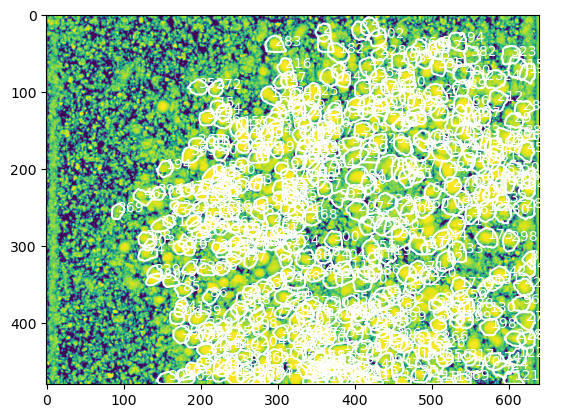

In [100]:
# Filter components by number of sessions the component could be found
n_reg = len(baseline) # minimal number of sessions that each component has to be registered in

# Use number of non-NaNs in each row to filter out components that were not registered in enough sessions
assignments_filtered = np.array(np.nan_to_num(assignments[np.sum(~np.isnan(assignments), axis=1) >= n_reg]), dtype=int);

# Ensure indices are within the valid range
valid_indices = assignments_filtered[:, 0] < spatial[-1].shape[1]
assignments_filtered = assignments_filtered[valid_indices]

# Use filtered indices to select the corresponding spatial components
spatial_filtered = spatial[0][:, assignments_filtered[:, 0]]

# Plot spatial components of the selected components on the template of the last session
visualization.plot_contours(spatial_filtered, templates[0]);
len(baseline)

In [ ]:
spatial_filtered.shape

(307200, 437)

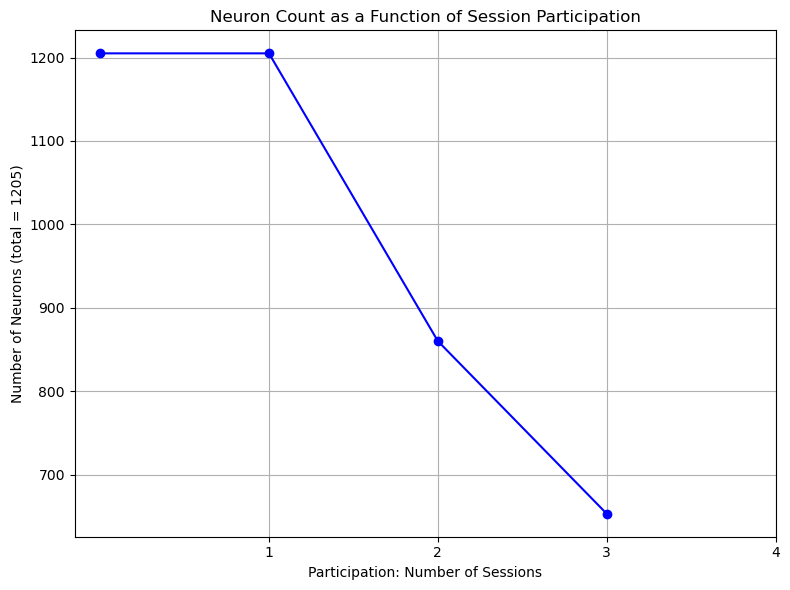

In [ ]:
# Define session range
session_range = np.arange(0, len(baseline))  # From 1 to 38 sessions
num_neurons_per_session = []

# Loop through different n_reg values
for n_reg in session_range:
    # Filter components based on the number of sessions they were registered in
    assignments_filtered = np.array(
        np.nan_to_num(assignments[np.sum(~np.isnan(assignments), axis=1) >= n_reg]), dtype=int
    )

    # Ensure indices are within the valid range
    valid_indices = assignments_filtered[:, 0] < spatial[-1].shape[1]
    assignments_filtered = assignments_filtered[valid_indices]

    # Store number of remaining neurons
    num_neurons_per_session.append(assignments_filtered.shape[0])

# Plot the results
plt.figure(figsize=(8, 6))
plt.plot(session_range, num_neurons_per_session, marker='o', linestyle='-', color='blue')

# Formatting
plt.xlabel("Participation: Number of Sessions")
plt.ylabel(f"Number of Neurons (total = {len(assignments)})")
plt.title("Neuron Count as a Function of Session Participation")
plt.grid(True)
plt.xticks(range(1, len(baseline)+1))  # Show every second session for clarity
plt.tight_layout()
plt.show()

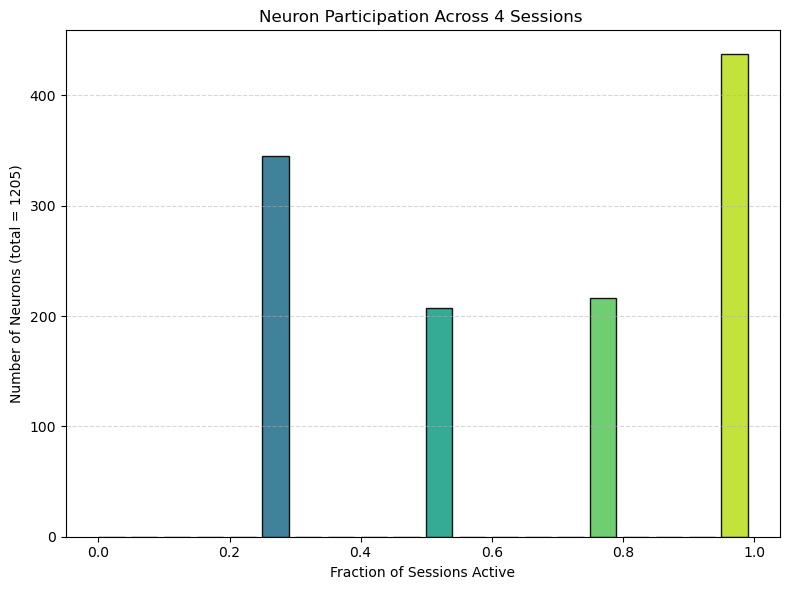

In [101]:
# Compute the fraction of sessions each neuron is active in
num_sessions = len(baseline)  # Total number of sessions (should be 38)
binary_map = ~np.isnan(assignments)  # Presence (True) or Absence (False)
fraction_active = np.sum(binary_map, axis=1) / num_sessions  # Fraction of active sessions

# Define bins for fractions (e.g., 0-0.1, 0.1-0.2, ..., 0.9-1.0)
bins = np.linspace(0, 1, 21)  # 10 bins from 0 to 1
hist_counts, bin_edges = np.histogram(fraction_active, bins=bins)
bin_centers = (bin_edges[:-1] + bin_edges[1:]) / 2

# Gradient color mapping (lighter for lower fractions, darker for higher)
colors = plt.cm.viridis(np.linspace(0.2, 0.9, len(hist_counts)))

# Sleek Bar plot of neuron participation
plt.figure(figsize=(8, 6))
plt.bar(bin_edges[:-1], hist_counts, width=0.04, color=colors, edgecolor='black', align='edge', alpha=0.9)

# Formatting
plt.xlabel("Fraction of Sessions Active")
plt.ylabel(f"Number of Neurons (total = {len(assignments)})")
plt.title(f"Neuron Participation Across {num_sessions} Sessions ")
plt.grid(axis='y', linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()

Above: Contour plots of neurons that were detected to be active in all # imaging sessions overlaid on the correlation image of the first imaging session

In [ ]:
traces = np.zeros(assignments_filtered.shape, dtype=np.ndarray)
for neuron in range(traces.shape[0]):
    for session in range(traces.shape[1]):
        traces[neuron,session] = cnmf_list[session].estimates.C[int(assignments_filtered[neuron,session])]

### Save CaImAn output data in .mat matrix for CellReg (FYI there's another ntebook just for that)
NxMxK matrix, where N is the number of neurons, M is the number of pixels in the y axis and K is the number of pixels in the x axis.

In [ ]:
date_pattern = r'/(\d{8})/'

for i, session in enumerate(file_paths):
    
    flipped_footprints = np.zeros((spatial[i].shape[1], dims[0], dims[1]))

    for component_number in range(spatial[i].shape[1]):
        
        # Get the current footprint and reshape it to original dimensions
        component_footprint = np.reshape(spatial[i][:, component_number].toarray(), dims, order='F')
        
        # Flip the matrix along the y-axis
        component_footprint_flipped = np.flipud(component_footprint)  # This flips the data vertically NOT SURE IF NEEDED
        
        # Store the flipped footprint in the new matrix
        flipped_footprints[component_number, :, :] = component_footprint_flipped



    data_to_save = {
        'flipped_footprints': flipped_footprints,  # The NxMxK matrix with flipped footprints
        'dims': dims,  # Original field of view dimensions
        'N_accepted': spatial[i].shape[1],  # Number of accepted components
    }

    # Define the save folder and filename
    date = re.search(date_pattern, session).group(1)
    save_directory = "/home/toor/Desktop/testSessions/CellReg/"
    save_filename = os.path.join(save_directory, f"{date}_spatial_footprints.mat")
    # Save to a MATLAB file using the save function
    # Ensure the directory exists
    os.makedirs(save_directory, exist_ok=True)
    io.savemat(save_filename, data_to_save)


AttributeError: 'NoneType' object has no attribute 'group'